In [1]:
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from main.operators import *
from main.VarQFT import *
from main.circuits import *

np.random.seed(0)

We consider two hydrogen atoms at positions $R$ and $-R$,
$$ H =  P_1^2 + P_2^2 - \frac{1}{|X_1-R|} - \frac{1}{|X_1+R|} - \frac{1}{|X_2-R|} - \frac{1}{|X_2+R|} + \frac{1}{|X_1-X_2|}$$

as always, we have the contribution of the kinetic energy, $P_1^2$ and $P_2^2$. The negative tems come from the Coulombian interaction between electrons and nuclei, and the last term is due to electron-electron interaction.

We start by setting the device to run the simulation

In [2]:
num_wires = 4  # qubits per subsystem
device = qml.device("lightning.qubit", wires=2 * num_wires)

and the Hamiltonian specified above,

In [22]:
wires1 = range(num_wires)
wires2 = range(num_wires, 2 * num_wires)

xrange = 3.5
X1, P1 = X_and_P_ops(range(num_wires), -xrange, xrange)
X2, P2 = X_and_P_ops(range(num_wires, 2 * num_wires), -xrange, xrange)

I1 = qml.Identity(wires1)
I2 = qml.Identity(wires2)

R = 1.75

H2 = [
    P1.pow(2),
    P2.pow(2),
    addition(X1, qml.s_prod(-R, I1), abs=True).pow(-1).s_prod(-1),
    addition(X1, qml.s_prod(R, I1), abs=True).pow(-1).s_prod(-1),
    addition(X2, qml.s_prod(-R, I2), abs=True).pow(-1).s_prod(-1),
    addition(X2, qml.s_prod(R, I2), abs=True).pow(-1).s_prod(-1),
    distance(X1, X2).pow(-1),
]
H2

[<Hamiltonian: terms=1, wires=[0, 1, 2, 3]>,
 <Hamiltonian: terms=1, wires=[4, 5, 6, 7]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3]>,
 <Hamiltonian: terms=1, wires=[4, 5, 6, 7]>,
 <Hamiltonian: terms=1, wires=[4, 5, 6, 7]>,
 <Hamiltonian: terms=1, wires=[0, 1, 2, 3, 4, 5, 6, 7]>]

We compute the eigenvalues and eigenstates in matrix representation using numpy for the sake of results verification

In [23]:
H2_matrix = tomatrix(H2)

vals, vecs = np.linalg.eigh(H2_matrix)
vec = vecs[:, 0]
vals[0:2]

array([-7.89094528, -7.89021799])

We define the variational ansatz, taking advantage of the symmetry of the system

In [24]:
num_layers = 10
circuit_def = RY_ansatz(
    2 * num_wires - 1, num_layers
)  # 1 qubit less before symmetrization
num_params = circuit_def.num_params

# (anti) symmetrization
ansatz_sym = symmetric_ansatz(circuit_def, antisymmetric=False)
var_state_sym = ansatz_sym.construct_circuit

ansatz_asym = symmetric_ansatz(circuit_def, antisymmetric=True)
var_state_asym = ansatz_asym.construct_circuit

### Ground state

Since the atoms have a large overlap, the more stable configuration is expected to be antisymmetric in this case. Thus, we define the instance of `VarFourier` with the antisymmetric ansatz to find the ground state.

In [25]:
varqft = VarFourier(H2, device, var_state_sym)

We run the optimization problem,

In [26]:
print(f"Optimal energy: {vals[0]:12.6f}")

params = 1e-3 * np.random.randn(num_params)

Params_ground, Energies_ground = varqft.run(params, max_iterations=800)

Optimal energy:    -7.890945
Step:    800, Energy:    -7.776290


and we have found the ground state!

In [27]:
minimum_energy = np.min(Energies_ground)
optimum_params = Params_ground[Energies_ground.index(minimum_energy)]
ground_state = varqft.state(optimum_params)

print(minimum_energy,ground_state)

-7.798451622001323 [ 4.34176616e-04+0.j  6.85202473e-04+0.j  3.00954724e-03+0.j
  5.82775024e-03+0.j  7.95709979e-03+0.j  3.89976658e-03+0.j
  3.65201215e-03+0.j  3.35489354e-03+0.j  3.99025667e-03+0.j
  7.10908106e-03+0.j  1.22689567e-02+0.j  2.03861832e-02+0.j
  1.45964878e-02+0.j  4.47633002e-03+0.j  3.79813550e-03+0.j
  3.30685417e-03+0.j  4.07881535e-03+0.j  1.21615896e-04+0.j
 -4.67934343e-03+0.j -3.78326681e-03+0.j  2.64886065e-03+0.j
  6.39714344e-03+0.j  3.39758100e-03+0.j  3.76584511e-04+0.j
  1.01103937e-02+0.j  1.83664063e-02+0.j  2.74605638e-02+0.j
  5.38374039e-02+0.j  3.81347146e-02+0.j  1.45004972e-02+0.j
  1.20369894e-02+0.j  7.97995111e-03+0.j  2.20852548e-03+0.j
  2.16875928e-03+0.j -4.77389539e-04+0.j -4.50829045e-03+0.j
 -4.53377402e-03+0.j  4.58358240e-03+0.j  5.88118377e-04+0.j
  5.23769527e-03+0.j  1.64610545e-02+0.j  3.19531808e-02+0.j
  6.14325809e-02+0.j  1.08272097e-01+0.j  7.90639792e-02+0.j
  3.97810807e-02+0.j  2.23978273e-02+0.j  1.24977879e-02+0.j
  8.3

In [36]:
np.save('optimum_params_H2sym_R=1,75',optimum_params)
np.save('optimum_state_H2sym_R=1,75',ground_state)
np.save('exact_state_H2sym_R=1,75', vec)
np.save('minimum_energy_H2sym_R=1,75', minimum_energy)

Best energy:    -7.798452


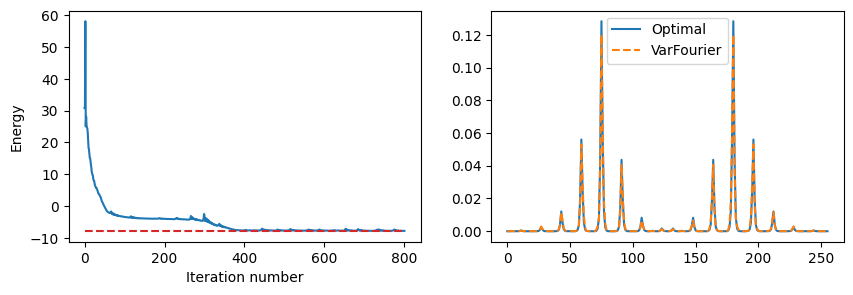

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

min_index = np.argmin(Energies_ground)
print(f"Best energy: {Energies_ground[min_index]:12.6f}")
ground_state = varqft.state(Params_ground[min_index])

ax[0].plot(Energies_ground)
ax[0].hlines(vals[0], 0, len(Energies_ground), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

ax[1].plot(np.abs(vecs[:, 0]) ** 2)
ax[1].plot(np.abs(ground_state) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"], loc="best")

In [29]:
fidelity = np.abs(np.vdot(ground_state, -vecs[:, 0])) ** 2
fidelity

0.9906095094201496

As before, the state has the space information mixed up. We can separate it, and make a plot on the configuration space

Text(0.5, 1.0, 'Ground state probability density')

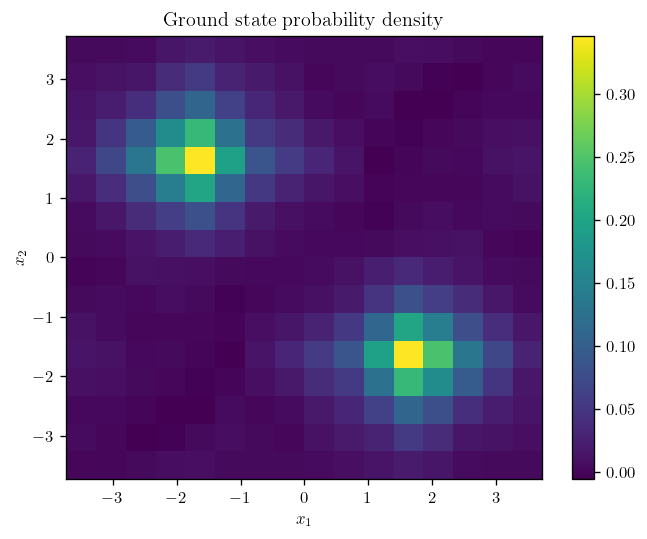

In [37]:
Mg = ground_state.reshape(2**num_wires, 2**num_wires)

plt.pcolormesh(X1.eigvals(), X2.eigvals(), np.real(Mg))
plt.colorbar()
plt.xlabel("$ x_1 $")
plt.ylabel("$ x_2 $")
plt.title("Ground state probability density")

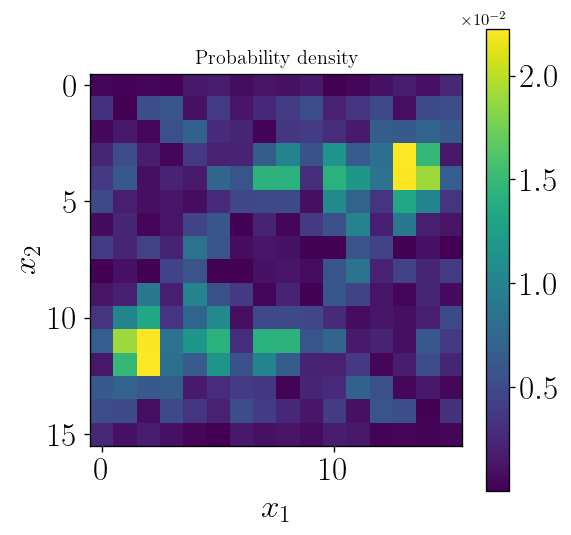

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format ="retina"
import matplotlib as mpl
mpl.rcParams["figure.dpi"] = 120
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker


M1 = ground_state.reshape(2**num_wires, 2**num_wires)

M2 = vec.reshape(2**num_wires, 2**num_wires)

M = np.abs(-M1-M2)

fig,ax = plt.subplots(1,1, figsize=(5,5))

im = ax.imshow(M, cmap = cm.viridis)
plt.title("Probability density")
plt.ylabel("$x_2$")
plt.xlabel("$x_1$")

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

cbformat = ScalarFormatter(useMathText=True)   # create the formatter
cbformat.set_powerlimits((-0,0)) 

ax.set_xlabel(r'$x_1$', fontsize = 20)
ax.set_ylabel(r'$x_2$', fontsize = 20)
#ax.set_zlabel(r"$\left|\psi(x)\right|^2$",fontsize=15)
ax.tick_params(axis='both', labelsize=20)
cbar = fig.colorbar(im, ax=ax, format=cbformat)
cbar.ax.tick_params(labelsize=20)  # Change the number (10) to adjust the size

#cbar.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True, useOffset=False))


plt.savefig("difwfs_H2sym_viridis.pdf",bbox_inches='tight',dpi=600)


### Excited state

We can repeat the process with a symmetric ansatz and we will find the first excited state,

In [11]:
varqft.set_var_state(var_state_sym)  # Set Symmtric ansatz

print(f"Optimal energy: {vals[1]:12.6f}")
Params_excited, Energies_excited = varqft.run(params, max_iterations=500)

Optimal energy:    -3.347574
Step:    500, Energy:    -3.327600


Best energy:    -3.340210


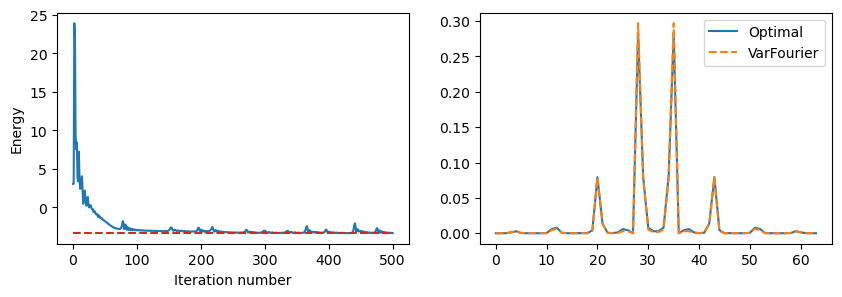

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

min_index = np.argmin(Energies_excited)
print(f"Best energy: {Energies_excited[min_index]:12.6f}")
excited_state = varqft.state(Params_excited[min_index])

ax[0].plot(Energies_excited)
ax[0].hlines(vals[1], 0, len(Energies_excited), colors="tab:red", linestyles="--")
ax[0].set_xlabel("Iteration number")
ax[0].set_ylabel("Energy")

ax[1].plot(np.abs(vecs[:, 1]) ** 2)
ax[1].plot(np.abs(excited_state) ** 2, "--")
ax[1].legend(["Optimal", "VarFourier"], loc="best")

In [13]:
fidelity = np.abs(np.vdot(excited_state, vecs[:, 1])) ** 2
fidelity

0.9957721716026608

Text(0.5, 1.0, 'Excited state probability density')

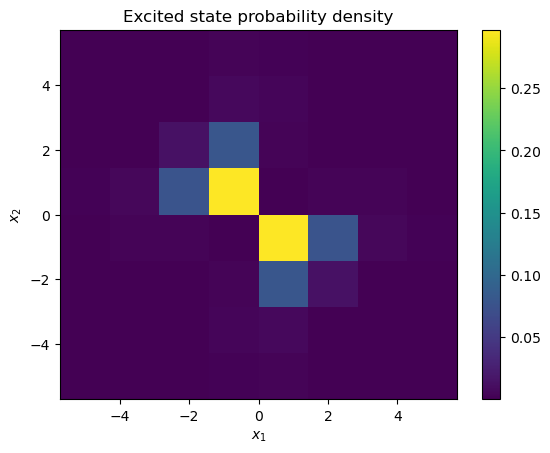

In [14]:
Me = excited_state.reshape(2**num_wires, 2**num_wires)

plt.pcolormesh(X1.eigvals(), X2.eigvals(), np.abs(Me) ** 2)
plt.colorbar()
plt.xlabel("$ x_1 $")
plt.ylabel("$ x_2 $")
plt.title("Excited state probability density")

Note, that this state is very similar to the ground state, but its symmetry is inverted

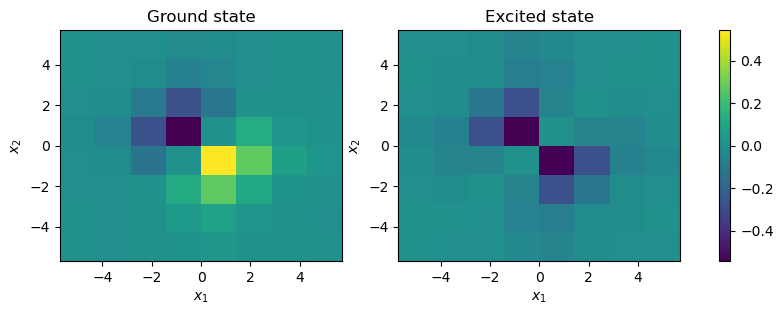

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))

minc = min(Mg.real.min(), Me.real.min())
maxc = max(Mg.real.max(), Me.real.max())

im = ax[0].pcolormesh(X1.eigvals(), X2.eigvals(), Mg.real, clim=(minc, maxc))
ax[0].set_title("Ground state")
ax[0].set_xlabel("$ x_1 $")
ax[0].set_ylabel("$ x_2 $")

ax[1].pcolormesh(X1.eigvals(), X2.eigvals(), Me.real, clim=(minc, maxc))
ax[1].set_title("Excited state")
ax[1].set_xlabel("$ x_1 $")
ax[1].set_ylabel("$ x_2 $")

fig.colorbar(im, ax=ax)